# Music Recomendations

In [ ]:
!pip install catboost==1.0.3
!pip install gensim==4.1.0
!pip install --upgrade numpy

In [1]:
!nvidia-smi

Wed Nov 24 10:50:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%cd /content
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
!tar -xf /content/wsdm_data.tar.gz
!mkdir data
!mv -t data members.csv song_extra_info.csv songs.csv train.csv
!git clone -b hw2 https://github.com/Sushentsev/recommendation-systems
%cd recommendation-systems/
!mv /content/data /content/recommendation-systems/hw2

/content
--2021-11-24 10:50:02--  https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
Resolving voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)... 52.95.171.72
Connecting to voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)|52.95.171.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613394184 (585M) [application/x-gzip]
Saving to: ‘wsdm_data.tar.gz’

wsdm_data.tar.gz    100%[===================>] 584.98M  23.6MB/s    in 26s     

2021-11-24 10:50:30 (22.2 MB/s) - ‘wsdm_data.tar.gz’ saved [613394184/613394184]

Cloning into 'recommendation-systems'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 100 (delta 50), reused 73 (delta 28), pack-reused 0
Receiving objects: 100% (100/100), 6.36 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/recommendation-systems


In [3]:
%cd /content/recommendation-systems/hw2

/content/recommendation-systems/hw2


In [4]:
import sys
sys.path.append("/content/recommendation-systems")

In [8]:
from datasets.members import MembersDataset
from datasets.songs import SongsDataset
from datasets.train import TrainDataset
from datasets.songs_info import SongsInfoDataset

from models.catboost_model import CatBoostModel
from models.embeddings_model import EmbeddingModel

from embeddings_builder import EmbeddingsBuilder

from plot import * 
from utils import * 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Подготовка данных

In [9]:
random_state = 42

Загрузим данные в память. 

In [10]:
%%time
members_dataset = MembersDataset.from_path("./data/members.csv")
songs_dataset = SongsDataset.from_path("./data/songs.csv")
train_dataset = TrainDataset.from_path("./data/train.csv")
songs_info_dataset = SongsInfoDataset.from_path("./data/song_extra_info.csv")

CPU times: user 56.6 s, sys: 1.59 s, total: 58.2 s
Wall time: 58 s


Построим признаки для песен и пользователей и посмотрим, что получилось. 

In [11]:
%%time
members_dataset = members_dataset.create_features()
songs_dataset = songs_dataset.create_features(songs_info_dataset)

CPU times: user 21.4 s, sys: 854 ms, total: 22.2 s
Wall time: 22.2 s


In [12]:
members_dataset.pandas_df.head(3)

,msno,city,gender,registered_via,bd_category,registration_init_year,expiration_date_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,<UNK>,7,<UNK>,2011,2017
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,<UNK>,7,<UNK>,2015,2017
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,<UNK>,4,<UNK>,2016,2017


In [13]:
songs_dataset.pandas_df.head(3)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,genres_count,artist_name_count,composer_count,lyricists_count,isrc_year
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,1,1,1,1,2014
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,1,1,3,1,-1
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,<UNK>,<UNK>,31.0,1,1,0,0,-1


Теперь добавим в обучающую выборку признаков из песен и пользователей. 

In [14]:
train_dataset = train_dataset.merge(members_dataset, on="msno", how="left")
train_dataset = train_dataset.merge(songs_dataset, on="song_id", how="left")

In [15]:
train_dataset.pandas_df.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,gender,registered_via,bd_category,registration_init_year,expiration_date_year,song_length,genre_ids,artist_name,composer,lyricist,language,genres_count,artist_name_count,composer_count,lyricists_count,isrc_year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,<UNK>,7,<UNK>,2012,2017,206471.0,359,Bastille,Dan Smith| Mark Crew,<UNK>,52.0,1.0,1.0,2.0,0.0,2016
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,female,9,young,2011,2017,284584.0,1259,Various Artists,<UNK>,<UNK>,52.0,1.0,1.0,0.0,0.0,1999
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,female,9,young,2011,2017,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,<UNK>,52.0,1.0,1.0,1.0,0.0,2006


Теперь преобразуем некоторые колонки категориальным значениям и заполнил пропуски. 

In [16]:
train_dataset.to_category(["msno", "song_id"])
train_dataset.fill_na_category(["source_system_tab", "source_screen_name", "source_type"])

In [17]:
train_dataset.pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 23 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   msno                    category
 1   song_id                 category
 2   source_system_tab       category
 3   source_screen_name      category
 4   source_type             category
 5   target                  int64   
 6   city                    category
 7   gender                  category
 8   registered_via          category
 9   bd_category             category
 10  registration_init_year  int64   
 11  expiration_date_year    int64   
 12  song_length             float64 
 13  genre_ids               category
 14  artist_name             category
 15  composer                category
 16  lyricist                category
 17  language                category
 18  genres_count            float64 
 19  artist_name_count       float64 
 20  composer_count          float64 
 21  lyricist

Все круто!

In [18]:
na_mask = train_dataset.pandas_df.isna().any(axis=1)
print(f"Количество записей, для которых не нашлось пользователя или песни: {sum(na_mask)}")

Количество записей, для которых не нашлось пользователя или песни: 114


Их оказалось не так много, уберем из нашего набора данных.

In [19]:
train_dataset = train_dataset.remove_by_mask(na_mask)

Так как **CatBoost** на CPU обучается достаточно долго (больше часа), то было решено обучать на GPU. Однако GPU не поддерживает группы больше 1023, поэтому тренировочный набор данных был уменьшен. При этом, желательно сохранить порядок записей.

In [20]:
train_dataset_sm = train_dataset.reduce_by_members(size=1023)

In [21]:
train_dataset_sm.pandas_df.target.value_counts()

1    3564182
0    3451109
Name: target, dtype: int64

Соотношение классов осталось тем же, все хорошо. Изменение размеров: 7377304 -> 7015291

In [22]:
print(f"{len(train_dataset)} -> {len(train_dataset_sm)}")

7377304 -> 7015291


## Задание 1

Построить рекомендации для каждого пользователя, произвести оценку качества с помощью 5-fold CV с метриками NDCG, ROC AUC per user.

При разработке признаков я умеренно не стал брать признаки, полученные с помощью матричных факторизаций, чтобы потом добавить неклассические эмбеддинги, полученные в задании 2. 

Для **CatBoost** необоходимо, чтобы данные были упорядочены по **queries**, поэтому будем обучать модели на упорядоченных данных, но эмбеддинги составлять на основе натурального порядка. 

In [23]:
train_dataset_sm_sort = train_dataset_sm.sort_by("msno")
model = CatBoostModel("YetiRank", 150, "GPU", random_state)
scores = model.cv_scores(train_dataset_sm_sort, n_splits=5)

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.37s	remaining: 3m 24s
1:	total: 2.58s	remaining: 3m 10s
2:	total: 3.79s	remaining: 3m 5s
3:	total: 5s	remaining: 3m 2s
4:	total: 6.22s	remaining: 3m
5:	total: 7.43s	remaining: 2m 58s
6:	total: 8.66s	remaining: 2m 56s
7:	total: 9.88s	remaining: 2m 55s
8:	total: 11.1s	remaining: 2m 53s
9:	total: 12.3s	remaining: 2m 52s
10:	total: 13.5s	remaining: 2m 50s
11:	total: 14.7s	remaining: 2m 49s
12:	total: 16s	remaining: 2m 48s
13:	total: 17.2s	remaining: 2m 46s
14:	total: 18.4s	remaining: 2m 45s
15:	total: 19.6s	remaining: 2m 44s
16:	total: 20.8s	remaining: 2m 42s
17:	total: 22s	remaining: 2m 41s
18:	total: 23.3s	remaining: 2m 40s
19:	total: 24.5s	remaining: 2m 39s
20:	total: 25.7s	remaining: 2m 37s
21:	total: 26.9s	remaining: 2m 36s
22:	total: 28.1s	remaining: 2m 35s
23:	total: 29.3s	remaining: 2m 34s
24:	total: 30.6s	remaining: 2m 32s
25:	total: 31.8s	remaining: 2m 31s
26:	total: 33s	remaining: 2m 30s
27:	total: 34.2s	remaining: 2m 29s
28:	total: 35.4s	remaining: 2m 27s
29:	total:

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.35s	remaining: 3m 20s
1:	total: 2.55s	remaining: 3m 8s
2:	total: 3.76s	remaining: 3m 4s
3:	total: 4.97s	remaining: 3m 1s
4:	total: 6.17s	remaining: 2m 59s
5:	total: 7.38s	remaining: 2m 57s
6:	total: 8.6s	remaining: 2m 55s
7:	total: 9.8s	remaining: 2m 54s
8:	total: 11s	remaining: 2m 52s
9:	total: 12.2s	remaining: 2m 51s
10:	total: 13.5s	remaining: 2m 50s
11:	total: 14.7s	remaining: 2m 48s
12:	total: 15.9s	remaining: 2m 47s
13:	total: 17.1s	remaining: 2m 46s
14:	total: 18.3s	remaining: 2m 45s
15:	total: 19.6s	remaining: 2m 43s
16:	total: 20.8s	remaining: 2m 42s
17:	total: 22s	remaining: 2m 41s
18:	total: 23.2s	remaining: 2m 39s
19:	total: 24.4s	remaining: 2m 38s
20:	total: 25.6s	remaining: 2m 37s
21:	total: 26.8s	remaining: 2m 36s
22:	total: 28s	remaining: 2m 34s
23:	total: 29.2s	remaining: 2m 33s
24:	total: 30.5s	remaining: 2m 32s
25:	total: 31.7s	remaining: 2m 30s
26:	total: 32.9s	remaining: 2m 29s
27:	total: 34.1s	remaining: 2m 28s
28:	total: 35.3s	remaining: 2m 27s
29:	to

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.35s	remaining: 3m 22s
1:	total: 2.56s	remaining: 3m 9s
2:	total: 3.76s	remaining: 3m 4s
3:	total: 4.96s	remaining: 3m
4:	total: 6.16s	remaining: 2m 58s
5:	total: 7.37s	remaining: 2m 56s
6:	total: 8.57s	remaining: 2m 55s
7:	total: 9.79s	remaining: 2m 53s
8:	total: 11s	remaining: 2m 52s
9:	total: 12.2s	remaining: 2m 50s
10:	total: 13.4s	remaining: 2m 49s
11:	total: 14.6s	remaining: 2m 48s
12:	total: 15.8s	remaining: 2m 46s
13:	total: 17.1s	remaining: 2m 45s
14:	total: 18.3s	remaining: 2m 44s
15:	total: 19.5s	remaining: 2m 43s
16:	total: 20.7s	remaining: 2m 41s
17:	total: 21.9s	remaining: 2m 40s
18:	total: 23.1s	remaining: 2m 39s
19:	total: 24.3s	remaining: 2m 37s
20:	total: 25.5s	remaining: 2m 36s
21:	total: 26.7s	remaining: 2m 35s
22:	total: 28s	remaining: 2m 34s
23:	total: 29.2s	remaining: 2m 33s
24:	total: 30.4s	remaining: 2m 31s
25:	total: 31.6s	remaining: 2m 30s
26:	total: 32.8s	remaining: 2m 29s
27:	total: 34s	remaining: 2m 28s
28:	total: 35.2s	remaining: 2m 26s
29:	tot

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.35s	remaining: 3m 20s
1:	total: 2.55s	remaining: 3m 8s
2:	total: 3.76s	remaining: 3m 4s
3:	total: 4.97s	remaining: 3m 1s
4:	total: 6.19s	remaining: 2m 59s
5:	total: 7.4s	remaining: 2m 57s
6:	total: 8.61s	remaining: 2m 55s
7:	total: 9.83s	remaining: 2m 54s
8:	total: 11s	remaining: 2m 53s
9:	total: 12.3s	remaining: 2m 51s
10:	total: 13.5s	remaining: 2m 50s
11:	total: 14.7s	remaining: 2m 49s
12:	total: 15.9s	remaining: 2m 47s
13:	total: 17.1s	remaining: 2m 46s
14:	total: 18.4s	remaining: 2m 45s
15:	total: 19.6s	remaining: 2m 43s
16:	total: 20.8s	remaining: 2m 42s
17:	total: 22s	remaining: 2m 41s
18:	total: 23.2s	remaining: 2m 40s
19:	total: 24.4s	remaining: 2m 38s
20:	total: 25.6s	remaining: 2m 37s
21:	total: 26.9s	remaining: 2m 36s
22:	total: 28.1s	remaining: 2m 35s
23:	total: 29.3s	remaining: 2m 33s
24:	total: 30.5s	remaining: 2m 32s
25:	total: 31.7s	remaining: 2m 31s
26:	total: 32.9s	remaining: 2m 30s
27:	total: 34.2s	remaining: 2m 28s
28:	total: 35.4s	remaining: 2m 27s
29:

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.39s	remaining: 3m 26s
1:	total: 2.62s	remaining: 3m 13s
2:	total: 3.83s	remaining: 3m 7s
3:	total: 5.05s	remaining: 3m 4s
4:	total: 6.27s	remaining: 3m 1s
5:	total: 7.49s	remaining: 2m 59s
6:	total: 8.71s	remaining: 2m 57s
7:	total: 9.92s	remaining: 2m 56s
8:	total: 11.1s	remaining: 2m 54s
9:	total: 12.4s	remaining: 2m 53s
10:	total: 13.6s	remaining: 2m 51s
11:	total: 14.8s	remaining: 2m 50s
12:	total: 16s	remaining: 2m 48s
13:	total: 17.3s	remaining: 2m 47s
14:	total: 18.5s	remaining: 2m 46s
15:	total: 19.7s	remaining: 2m 45s
16:	total: 20.9s	remaining: 2m 43s
17:	total: 22.1s	remaining: 2m 42s
18:	total: 23.4s	remaining: 2m 41s
19:	total: 24.6s	remaining: 2m 39s
20:	total: 25.8s	remaining: 2m 38s
21:	total: 27s	remaining: 2m 37s
22:	total: 28.2s	remaining: 2m 35s
23:	total: 29.5s	remaining: 2m 34s
24:	total: 30.7s	remaining: 2m 33s
25:	total: 31.9s	remaining: 2m 32s
26:	total: 33.1s	remaining: 2m 30s
27:	total: 34.4s	remaining: 2m 29s
28:	total: 35.6s	remaining: 2m 28s
29

In [24]:
print(f"Average NDCG: {np.mean(scores['NDCG']):.4f}")
print(f"Average ROC AUC per user: {np.mean(scores['ROC_AUC']):.4f}")

Average NDCG: 0.8341
Average ROC AUC per user: 0.6416


## Задание 2

Построить неклассические эмбеддинги и исследовать их полезность.

In [26]:
%%time
embeddings = EmbeddingsBuilder(embedding_dim=100, random_state=random_state)
embeddings = embeddings.fit(train_dataset)
save_pickle(embeddings, "embeddings.pkl")

CPU times: user 22min 10s, sys: 9.49 s, total: 22min 20s
Wall time: 20min 25s


In [27]:
embeddings = load_pickle("embeddings.pkl")

Посмотрим на похожие песни и пользователей, визуализировав их с помощью PCA. Будем называть песни похожими, если они принадлежат к одному жанру.

In [28]:
songs, genres = songs_dataset.similar_songs(n_groups=5)

In [29]:
np.unique(genres, return_counts=True)

(array(['1609', '2022', '2122', '465', '958'], dtype=object),
 array([166457, 168870, 139938, 567911, 176349]))

Так как есть очень большой класс, уберем его. 

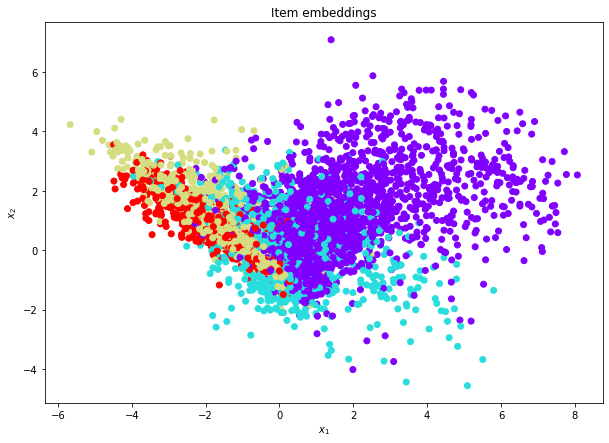

In [31]:
genres_mask = (genres != "465")
songs_mask = np.array([embeddings.has_item(song) for song in songs])

mask = genres_mask & songs_mask
plot_similar(embeddings.get_item_embeddings(songs[mask]), genres[mask], "Item embeddings")

Как можно видеть, получились некоторые кластеры, обучим модель. 

In [32]:
%%time
model = EmbeddingModel(embeddings)
scores = model.cv_scores(train_dataset_sm_sort, n_splits=5)

CPU times: user 2min 28s, sys: 6.07 s, total: 2min 34s
Wall time: 2min 34s


In [33]:
print(f"Average NDCG: {np.mean(scores['NDCG']):.4f}")
print(f"Average ROC AUC per user: {np.mean(scores['ROC_AUC']):.4f}")

Average NDCG: 0.9159
Average ROC AUC per user: 0.7168


Как можно видеть, метрики лучше!. Возможно, это зависит от признаков, многие признаки были нерелеватные.

**TODO:** добавить в деревья, посчитать SHAP values.